In [89]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

# Setup

In [90]:
fig_height = 3.5

In [91]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot find name 'requires'. Did you mean 'require'?" : "Cannot find name (suggestion).",
    "Cannot find name 'One'. Did you mean 'one'?": "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused",
    "Type annotations can only be used in TypeScript files." : "Type annotations",
    "A 'return' statement can only be used within a function body.": "Return outside function",
    "Property 'setState' does not exist on type 'UnicornEditor'.": "Property doesn't exist on type",
    "Property 'returns' does not exist on type '(arg0: any) => void'." : "Property doesn't exist on type", #first error message the values r specific
    "Top-level 'await' expressions are only allowed when the 'module' option is set to 'es2022' 'esnext' 'system' 'node16' or 'nodenext' and the 'target' option is set to 'es2017' or higher.": "Top level await",
    "Cannot find name 'it'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (it).",
    "Parsing error: Unexpected token": "Parsing.unexpectedToken",
    "Parsing error: 'import' and 'export' may appear only with 'sourceType: module'": "Parsing.importExport",
    "Parsing error: Unexpected character": "Parsing.unexpectedCharacter",
    "Parsing error: Identifier has already been declared": "Parsing.alreadyDeclared",
    "Parsing error: Invalid regular expression" : "Parsing.invalidRegEx",
    "Parsing error: Assigning to rvalue": "Parsing.assignedToRvalue",
    "Parsing error: Unterminated regular expression": "Parsing.unterminatedRegEx",
    "Parsing error: Identifier directly after number": "Parsing.identifierAfterNumber",
    "Parsing error: Unterminated string constant": "Parsing.unterminatedStringConstant",
    "Parsing error: Expecting Unicode escape sequence \\uXXXX":  "Parsing.expectedUnicodeEscape",
    "Parsing error: Cannot use keyword 'await' outside an async function": "Parsing.awaitNotInAsync",
    "Parsing error: Reserved keyword" : "Parsing.reservedKeyword",
    "Parsing error: 'return' outside of function" : "Parsing.returnNotInFunction",
    "Parsing error: Unterminated template": "Parsing.unterminatedTemplate",
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

In [190]:
# figures
#i cant spell occurrences...
def top10Errors(df, column, label="Occurrences (million)", title="Common Error Types", saveas='commonErrorTypes', getLabels=getLabels, xlim=8000000, format=lambda x, p: format(int(x/1000000), ','), color = "ncc", df2 = None):
    if color == "ncc": color = "darkorange"
    elif color == "ncq": color = "darkblue"
    
    top10_df = df.nlargest(10, [column]).iloc[::-1]
    top10_df2 = None
    if(isinstance(df2, DataFrame)): 
        # get the same values
        keys = list(top10_df["CODE"])
        top10_df2 = df2[df2["CODE"].isin(keys)].iloc[::-1]
        top10_df2 = top10_df2.set_index("CODE")
        top10_df2 = top10_df2.reindex(keys)
        top10_df2 = top10_df2.reset_index()
        

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex="col", width_ratios=[3, 2])
    fig.set_size_inches(4, fig_height)

    ax1.barh(getLabels(top10_df["ERROR"]), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax1.barh(getLabels(top10_df2["ERROR"]), top10_df2[column], color=(0,0,0,0.3), hatch="//")
    ax = ax2.barh(range(0, 10), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax2.barh(range(0, 10), top10_df2[column], color=(0,0,0,0.3), hatch="//")

    fig.subplots_adjust(wspace=0.15)

    ax1.set_xlim(0, 800000)
    ax2.set_xlim(1000000, 9500000)

    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(labelleft=False, left=False)
    ax2.yaxis.tick_right()

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)

    ax1.set_xlabel(label, x=1)
    ax1.set_ylabel("Errors")
    # ax.set_xlim(0, xlim)
    

    ax1.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/1000000))
    ax2.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/1000000))

    # ax2.get_xaxis().set_major_formatter(
    #     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/100), ',')))
    # ax1.tick_params(axis='both', which='major', labelsize=8.5)
    #fig.set_title(title)

    labels = []
    for n in top10_df[column]:
        if(n>1000000):
            n = str(round(n/1000000, 1)) + "m"
        else:
            n = int(n)
        labels.append(n)
    ax2.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    ax1.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    plt.savefig(saveas, bbox_inches = "tight")
    plt.show()

In [93]:
#classes
class Log:

    def __init__(self, filename, heading = "ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
        rows = []
        self.snippets = None
        self.noErrors = None
        self.totalErrors = None
        self.fixed = None
        self.empty = None
        self.loc = None

        if isinstance(filename, str):
            file = open(filename, encoding="utf8")
            lines = file.readlines()
        else:
            lines = filename

        headings = []
        csv_mode = False
        for line in lines:
            line = line.strip()
            if line.startswith(heading):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                to = len(headings)-1
                columns = ["".join(parts[0:-to])]
                for p in parts[-to:]:
                    p = p.strip()
                    if p == "true":
                        p = True
                    elif p == "undefined":
                        p = False
                    elif p == "":
                        p = None
                    else:
                        p = float(p)
                    columns.append(p)
                # columns += [float(p.strip()) for p in parts[-to:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors:"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Total errors:")):
                self.totalErrors = int(line.split(":")[1])
            if(line.startswith("Fixed:")):
                self.fixed = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Code lines:")):
                self.loc = int(line.split(":")[1])
            if(line.startswith("Snippets no lines:")):
                self.empty = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

    def getLines(filename, heading, end):
        file = open(filename, encoding="utf8")
        lines = file.readlines()
        record = True
        newLines = []
        for line in lines:
            if line.startswith("--------"):
                record = False
            if line.startswith(heading):
                record = True
            if end and line.startswith(end):
                reocrd = False
            if record:
                newLines.append(line)
        return newLines
    

In [94]:
#load files
DATA_DIR = "../data";
ESLINT_DIR = DATA_DIR + "/eslintErrors.log"
SAMPLE_DIR = DATA_DIR + "/384-sample.log"
ERRORS_DIR = DATA_DIR + "/allErrors.log"
DELETION_DIR = DATA_DIR + "/afterDeletion.log"
TS_DIR = DATA_DIR + "/tsCodeFixes.log"

#eslint logs for comparison
#eslint_heading = "ERROR, SEVERITY, FATAL, NUM OCCURANCES, NUM AFFECTED SNIPPETS, PERCENT" # for old file format
eslint_p_errors = Log(Log.getLines(ESLINT_DIR, "PARSING ERROR ANALYSIS", "RULE ANALYSIS"))
eslint_errors = Log(Log.getLines(ESLINT_DIR, "RULE ANALYSIS", "ESLINT FIX ANALYSIS"))
eslint_justfixes = Log(Log.getLines(ESLINT_DIR, "ESLINT FIX ANALYSIS", "DELETION ANALYSIS"))
eslint_justdeletion = Log(Log.getLines(ESLINT_DIR, "DELETION ANALYSIS", "ALL FIXES"))
eslint_allfixes = Log(Log.getLines(ESLINT_DIR, "ALL FIXES", None))

errors = Log(ERRORS_DIR)
deletion = Log(DELETION_DIR)
ts = Log(TS_DIR)


# Eslint

## Parsing Error Analysis

ESLint with parsing errors enabled only.

### Overview

In [95]:
def overview(e, c = None):
    print("Total Snippets: " + str(e.snippets))
    print("Total Errors: " + str(e.totalErrors))
    if c:
        print("Error Difference (+/-): " + str(-(c.totalErrors - e.totalErrors)))
    print("Average: " + str(
        e.totalErrors / e.snippets
    ))
    print("Total LOC: " + str(e.loc))
    if c:
        locdif = -(e.loc - c.loc)
        print("LOC Difference (+/-): " + str(-(c.loc - e.loc)))
    print("Snippets with no Errors: " + str(e.noErrors) + "/" + str(e.snippets) + "(" + str(e.noErrors/e.snippets) + ")")
    if c:
        print("Snippets with no Errors Difference (+/-): " + str(-(c.noErrors - e.noErrors)))
        print("Snippets increased by: " + str(
            (e.noErrors - c.noErrors)/ c.noErrors
        ))
    wE = e.snippets-e.noErrors
    print("Snippets with Errors: " + str(wE) + "/" + str(e.snippets) + "(" + str(1 - e.noErrors/e.snippets) + ")")
    if c:
         wEc = c.snippets-c.noErrors
         print("Snippets with Errors Difference (+/-): " + str(-(wEc - wE)))
    print("Average: " + str(
        e.totalErrors / wE
    ))
    print("Snippets Fixed " + str(e.fixed) + "/" + str(e.snippets) + "(" + str(e.fixed/e.snippets) + ")")
    if c:
        fixdif = e.fixed - c.fixed
        print("Snippets Fixed Difference (+/-): " + str(-(c.fixed - e.fixed)))
        if fixdif:
            print("Average Deleted per Fixed: " + str(locdif/fixdif))
    print("Snippets Empty " + str(e.empty) + "/" + str(e.snippets) + "(" + str(e.empty/e.snippets) + ")")
    if c:
        emptydif = e.empty - c.empty
        print("Snippets Empty Difference (+/-): " + str(emptydif))
        print("Snippets No Error Non-Empty " + str((e.noErrors - c.noErrors)-emptydif) + "/" + str((e.noErrors - c.noErrors)) + "(" + str(((e.noErrors - c.noErrors)-emptydif)/(e.noErrors - c.noErrors)) + ")")
        
p_errors_df = eslint_p_errors.errors
overview(eslint_p_errors)

Total Snippets: 2161911
Total Errors: 755772
Average: 0.3495851586859959
Total LOC: 17092494
Snippets with no Errors: 1406139/2161911(0.6504148413140042)
Snippets with Errors: 755772/2161911(0.3495851586859958)
Average: 1.0
Snippets Fixed 0/2161911(0.0)
Snippets Empty 9964/2161911(0.004608885379647913)


### Top 10 Errors

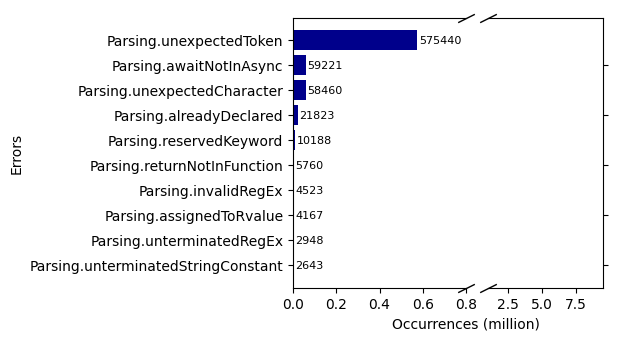

In [96]:
top10Errors(p_errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypesParsing", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Parsing Errors",
    color = "ncq")

## Error Analysis

ESLint with rules enabled, and warnings filtered out for these results.

Warnings don't impact code runnability, some exist just to enable formatting fixes in NCQ.

Results are the same as only parsing errors for the top 10.

In [97]:
errors_df = eslint_errors.errors
errors_df = errors_df[errors_df["CATEGORY"] == 2]
overview(eslint_errors, eslint_p_errors)

#eslint errors account for x% of errors
print("Parsing Error Percent: " + str(eslint_errors.totalErrors - eslint_p_errors.totalErrors) + "/" + str(eslint_errors.totalErrors)
 + " (" + str((eslint_errors.totalErrors - eslint_p_errors.totalErrors)/eslint_errors.totalErrors) + ")"
)

Total Snippets: 2161911
Total Errors: 757983
Error Difference (+/-): 2211
Average: 0.35060786498611646
Total LOC: 17092494
LOC Difference (+/-): 0
Snippets with no Errors: 1404765/2161911(0.6497792924870636)
Snippets with no Errors Difference (+/-): -1374
Snippets increased by: -0.0009771437958836218
Snippets with Errors: 757146/2161911(0.35022070751293644)
Snippets with Errors Difference (+/-): 1374
Average: 1.0011054671093818
Snippets Fixed 0/2161911(0.0)
Snippets Fixed Difference (+/-): 0
Snippets Empty 9964/2161911(0.004608885379647913)
Snippets Empty Difference (+/-): 0
Snippets No Error Non-Empty -1374/-1374(1.0)
Parsing Error Percent: 2211/757983 (0.002916951963302607)


### Top 10

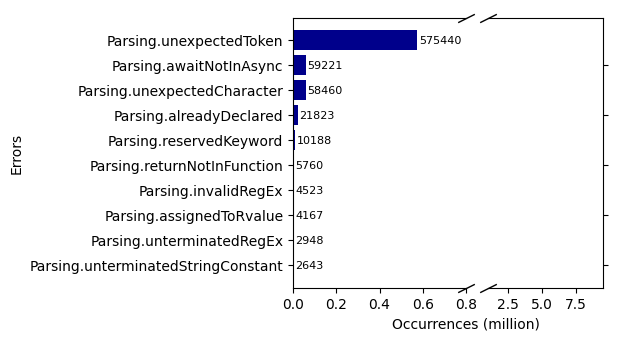

In [98]:
top10Errors(errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypes", xlim=700000,
    format = lambda x, p: format(int(x/100000), ','),
    title="Most Common ESLint Errors",
    color = "ncq")

## Impact of ESLint's fixes

In [99]:
es_errors_df = eslint_justfixes.errors
overview(eslint_justfixes, eslint_errors)

#impact of eslints built in fixes is negligible, in fact, somehow increased errors by 1 

Total Snippets: 2161911
Total Errors: 757984
Error Difference (+/-): 1
Average: 0.35060832753984783
Total LOC: 17092491
LOC Difference (+/-): -3
Snippets with no Errors: 1404764/2161911(0.6497788299333321)
Snippets with no Errors Difference (+/-): -1
Snippets increased by: -7.118628382683225e-07
Snippets with Errors: 757147/2161911(0.35022117006666786)
Snippets with Errors Difference (+/-): 1
Average: 1.001105465649339
Snippets Fixed 432/2161911(0.00019982321196385975)
Snippets Fixed Difference (+/-): 432
Average Deleted per Fixed: 0.006944444444444444
Snippets Empty 9964/2161911(0.004608885379647913)
Snippets Empty Difference (+/-): 0
Snippets No Error Non-Empty -1/-1(1.0)


## All Fixes

In [100]:
af_errors_df = eslint_allfixes.errors
af_errors_df = af_errors_df[af_errors_df["CATEGORY"] == 2]
overview(eslint_allfixes, eslint_errors)

Total Snippets: 2161911
Total Errors: 130569
Error Difference (+/-): -627414
Average: 0.06039517815488241
Total LOC: 13631447
LOC Difference (+/-): -3461047
Snippets with no Errors: 2033506/2161911(0.9406057881198625)
Snippets with no Errors Difference (+/-): 628741
Snippets increased by: 0.44757735279566335
Snippets with Errors: 128405/2161911(0.05939421188013749)
Snippets with Errors Difference (+/-): -628741
Average: 1.0168529262879171
Snippets Fixed 755729/2161911(0.34956526887554573)
Snippets Fixed Difference (+/-): 755729
Average Deleted per Fixed: 4.579746178855118
Snippets Empty 309756/2161911(0.14327879362286422)
Snippets Empty Difference (+/-): 299792
Snippets No Error Non-Empty 328949/628741(0.5231868130120352)


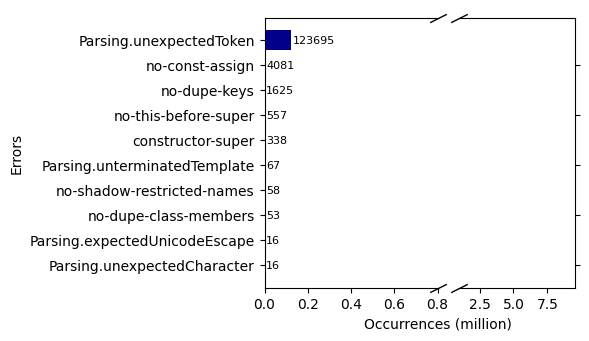

In [101]:
top10Errors(af_errors_df, "NUM OCCURANCES", saveas="eslint-commonErrorTypesDeletion", xlim=700000,
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common ESLint Errors After Fixes",
    color = "ncq")


# TypeScript

## Error Analysis

### Overview

In [102]:
errors_df = errors.errors
overview(errors, eslint_errors)

#there is only one snippet with a non-1 category?
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["ERROR"]))
print(list(errors_df[errors_df["CATEGORY"] != 1.0]["FIRST ID"]))

Total Snippets: 2161911
Total Errors: 14707149
Error Difference (+/-): 13949166
Average: 6.802846648173769
Total LOC: 17092494
LOC Difference (+/-): 0
Snippets with no Errors: 569201/2161911(0.2632860464653725)
Snippets with no Errors Difference (+/-): -835564
Snippets increased by: -0.5948069605948326
Snippets with Errors: 1592710/2161911(0.7367139535346274)
Snippets with Errors Difference (+/-): 835564
Average: 9.234040723044371
Snippets Fixed 0/2161911(0.0)
Snippets Fixed Difference (+/-): 0
Snippets Empty 9964/2161911(0.004608885379647913)
Snippets Empty Difference (+/-): 0
Snippets No Error Non-Empty -835564/-835564(1.0)
['Dynamic imports can only accept a module specifier and an optional assertion as arguments']
[241928.0]


### Most common errors (occurrences)

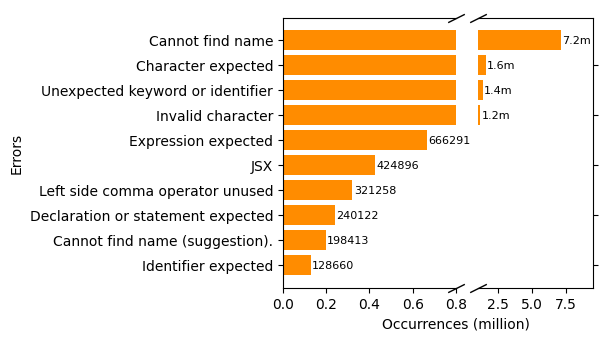

In [103]:
errors_df = errors.errors
top10Errors(errors_df, "NUM OCCURANCES", saveas="commonErrorTypes", title="Most Common Errors")


### Most common errors (snippets affected)

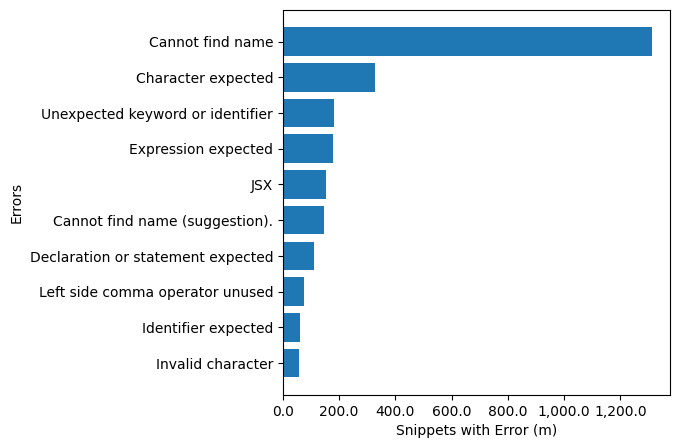

In [104]:
top10_df = errors_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000, ',')))

## Post TS Code Fixes

### Overview

In [105]:
ts_df = ts.errors
overview(ts, errors)

Total Snippets: 2161911
Total Errors: 14096112
Error Difference (+/-): -611037
Average: 6.520209203801636
Total LOC: 18221777
LOC Difference (+/-): 1129283
Snippets with no Errors: 648814/2161911(0.30011133668314743)
Snippets with no Errors Difference (+/-): 79613
Snippets increased by: 0.13986799039355166
Snippets with Errors: 1513097/2161911(0.6998886633168526)
Snippets with Errors Difference (+/-): -79613
Average: 9.316066319608062
Snippets Fixed 602629/2161911(0.278748292598539)
Snippets Fixed Difference (+/-): 602629
Average Deleted per Fixed: -1.8739274080736241
Snippets Empty 9964/2161911(0.004608885379647913)
Snippets Empty Difference (+/-): 0
Snippets No Error Non-Empty 79613/79613(1.0)


### Most common occurances

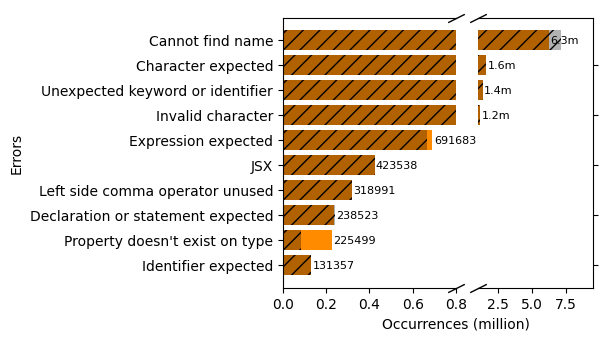

In [191]:
top10Errors(ts_df, "NUM OCCURANCES", saveas="commonErrorTypesTS", title="Most Common Errors After CodeFixes", df2 = errors_df)

### Difference

Identifier expected.
Identifier expected.
2697.0
0   -6125080.0
1   -1563370.0
2   -1135727.0
3    -860439.0
4    -266787.0
5     242753.0
6     867310.0
7    1151207.0
8    1372655.0
9    7026823.0
Name: NUM OCCURANCES, dtype: float64


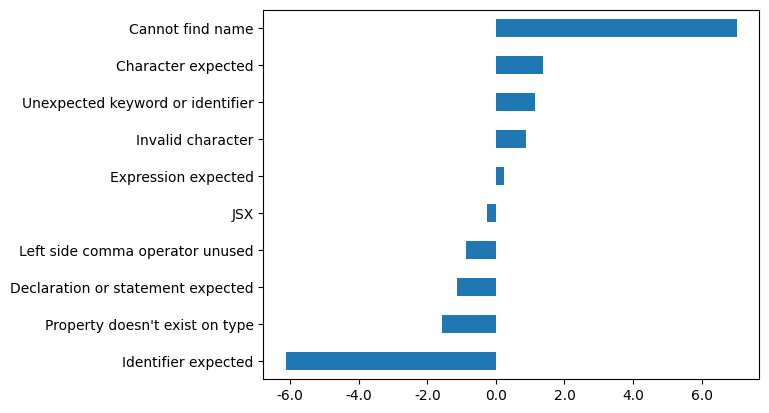

In [207]:
column = "NUM OCCURANCES"
df = ts_df
df2 = errors_df


top10_df = ts_df.nlargest(10, [column]).iloc[::-1]
top10_df2 = None
if(isinstance(df2, DataFrame)): 
    # get the same values in same order
    keys = list(top10_df["CODE"])
    top10_df2 = df2[df2["CODE"].isin(keys)].iloc[::-1]
    top10_df2 = top10_df2.set_index("CODE")
    top10_df2 = top10_df2.reindex(keys)
    top10_df2 = top10_df2.reset_index()

for i in range(0, 10):
    print(list(top10_df["ERROR"])[i])
    print(list(top10_df2["ERROR"])[i])
    print(list(top10_df["NUM OCCURANCES"])[i] - list(top10_df2["NUM OCCURANCES"])[i])

#get difference
diff = top10_df2[column]-top10_df[column]
print(diff)
ax = diff.plot.barh()
ax.set_yticklabels(getLabels(list(top10_df2["ERROR"])))
ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/1000000))


## Post Deletion Analysis

### Overview

In [107]:
deletion_df = deletion.errors
overview(deletion, errors)

Total Snippets: 2161911
Total Errors: 986944
Error Difference (+/-): -13720205
Average: 0.4565146298806935
Total LOC: 12876799
LOC Difference (+/-): -4215695
Snippets with no Errors: 1583239/2161911(0.7323331071445587)
Snippets with no Errors Difference (+/-): 1014038
Snippets increased by: 1.781511276332965
Snippets with Errors: 578672/2161911(0.2676668928554413)
Snippets with Errors Difference (+/-): -1014038
Average: 1.7055326679016782
Snippets Fixed 1332238/2161911(0.6162316580099736)
Snippets Fixed Difference (+/-): 1332238
Average Deleted per Fixed: 3.16437078059626
Snippets Empty 706316/2161911(0.3267091013459851)
Snippets Empty Difference (+/-): 696352
Snippets No Error Non-Empty 317686/1014038(0.31328806218307403)


In [108]:
#compare to eslint
overview(deletion, eslint_allfixes)

Total Snippets: 2161911
Total Errors: 986944
Error Difference (+/-): 856375
Average: 0.4565146298806935
Total LOC: 12876799
LOC Difference (+/-): -754648
Snippets with no Errors: 1583239/2161911(0.7323331071445587)
Snippets with no Errors Difference (+/-): -450267
Snippets increased by: -0.22142398399611313
Snippets with Errors: 578672/2161911(0.2676668928554413)
Snippets with Errors Difference (+/-): 450267
Average: 1.7055326679016782
Snippets Fixed 1332238/2161911(0.6162316580099736)
Snippets Fixed Difference (+/-): 576509
Average Deleted per Fixed: 1.3089960434269023
Snippets Empty 706316/2161911(0.3267091013459851)
Snippets Empty Difference (+/-): 396560
Snippets No Error Non-Empty -846827/-450267(1.8807218827939867)


### Most common errors (occurances)

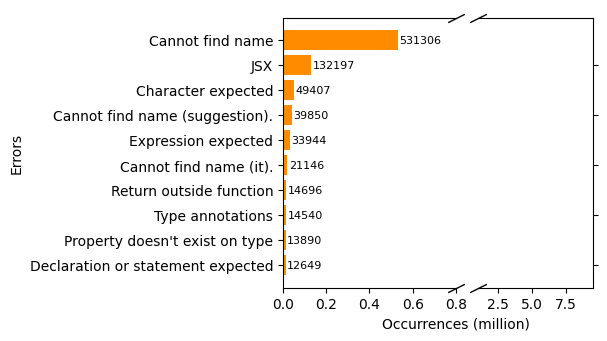

In [109]:
top10Errors(deletion_df, "NUM OCCURANCES", saveas="commonErrorTypesDeletion", title="Most Common Errors After Fixes")


### Most common errors (snippets affected)

[Text(1, 0, '10203'),
 Text(1, 0, '10414'),
 Text(1, 0, '11177'),
 Text(1, 0, '11412'),
 Text(1, 0, '14534'),
 Text(1, 0, '29979'),
 Text(1, 0, '35611'),
 Text(1, 0, '41966'),
 Text(1, 0, '57503'),
 Text(1, 0, '398311')]

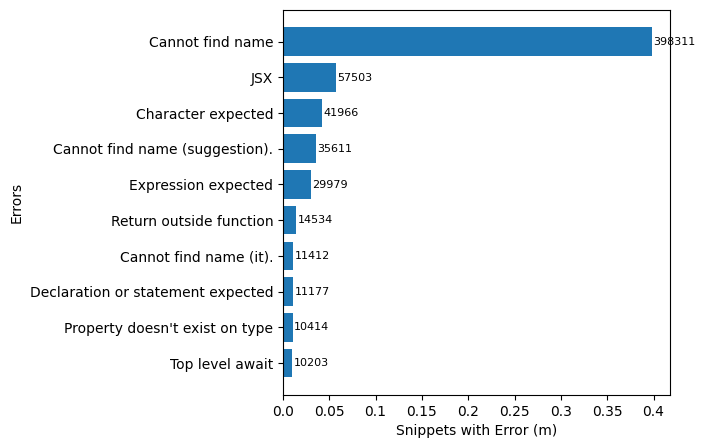

In [110]:
top10_df = deletion_df.nlargest(10, ['NUM AFFECTED SNIPPETS']).iloc[::-1]

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax1 = ax.barh(getLabels(top10_df["ERROR"]), top10_df["NUM AFFECTED SNIPPETS"])
ax.set_xlabel("Snippets with Error (m)")
ax.set_ylabel("Errors")
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(x/1000000, ',')))

labels = []
for n in top10_df["NUM AFFECTED SNIPPETS"]:
    if(n>1000000):
        n = str(round(n/1000000, 1)) + "m"
    else:
        n = int(n)
    labels.append(n)
ax.bar_label(ax1, label_type='edge', labels=labels, padding=1, size=8)